In [2]:
import pandas as pd
import numpy as np

# Data

data = {"Year":                        np.array([1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985]),
        "Fatal accidents":             np.array([24, 25, 31, 31, 22, 21, 26, 20, 16, 22]),
        "Passenger deaths":            np.array([734, 516, 754, 877, 814, 362, 764, 809, 223, 1066]),
        "Death rate":                  np.array([0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15]),
        "Miles flown [100 mln miles]": np.array([3863, 4300, 5027, 5481, 5814, 6033, 5877, 6223, 7433, 7107])}

df = pd.DataFrame(data)
df

,Year,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
0,1976,24,734,0.19,3863
1,1977,25,516,0.12,4300
2,1978,31,754,0.15,5027
3,1979,31,877,0.16,5481
4,1980,22,814,0.14,5814
5,1981,21,362,0.06,6033
6,1982,26,764,0.13,5877
7,1983,20,809,0.13,6223
8,1984,16,223,0.03,7433
9,1985,22,1066,0.15,7107


## Task 1
Using the data from following table create a model predicting number of passenger deaths. Use poisson distribution, assume that the rate is constant for all years and not depending on anything. Select appropriate priors, perform prior predictive checks, fit the model and using posterior predictive distribution predict the death rates from the model.

(array([1., 1., 0., 1., 0., 0., 4., 2., 0., 1.]),
 array([ 223. ,  307.3,  391.6,  475.9,  560.2,  644.5,  728.8,  813.1,
         897.4,  981.7, 1066. ]),
 <a list of 10 Patch objects>)

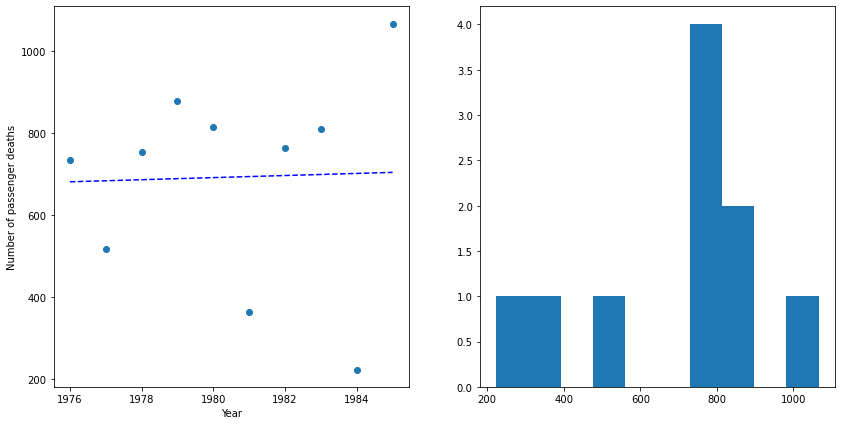

In [6]:
import matplotlib.pyplot as plt

# Show raw data
plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)

plt.plot(df["Year"].values, df["Passenger deaths"].values, "o")
plt.ylabel("Number of passenger deaths")
plt.xlabel("Year")
# Fit line to data
a, b = np.polyfit(df["Year"].values, df["Passenger deaths"].values, 1)
plt.plot(df["Year"].values, df["Year"].values*a+b, "--", color='blue')

plt.subplot(1, 2, 2)
plt.hist(df["Passenger deaths"])

In [15]:
avg_deaths = np.round(df["Passenger deaths"].mean())
avg_deaths

692.0

In [43]:
import stan_utility
model_prior = stan_utility.compile_model('prior_1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_58f2beb2cd6acc982ad0de7b16db8f2a NOW.


In [46]:
import scipy.stats as stats

sim = model_prior.sampling(data=dict(),
                           iter=1000,
                           warmup=0,
                           algorithm='Fixed_param',
                           seed=43541)

lambda_sim = sim.extract()['lambda']
deaths_sim = sim.extract()['deaths']

c:\users\mateusz\anaconda3\envs\data_analytics\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\mateusz\anaconda3\envs\data_analytics\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)
c:\users\mateusz\anaconda3\envs\data_analytics\lib\site-packages\numpy\lib\histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
c:\users\mateusz\anaconda3\envs\data_analytics\lib\site-packages\numpy\lib\histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


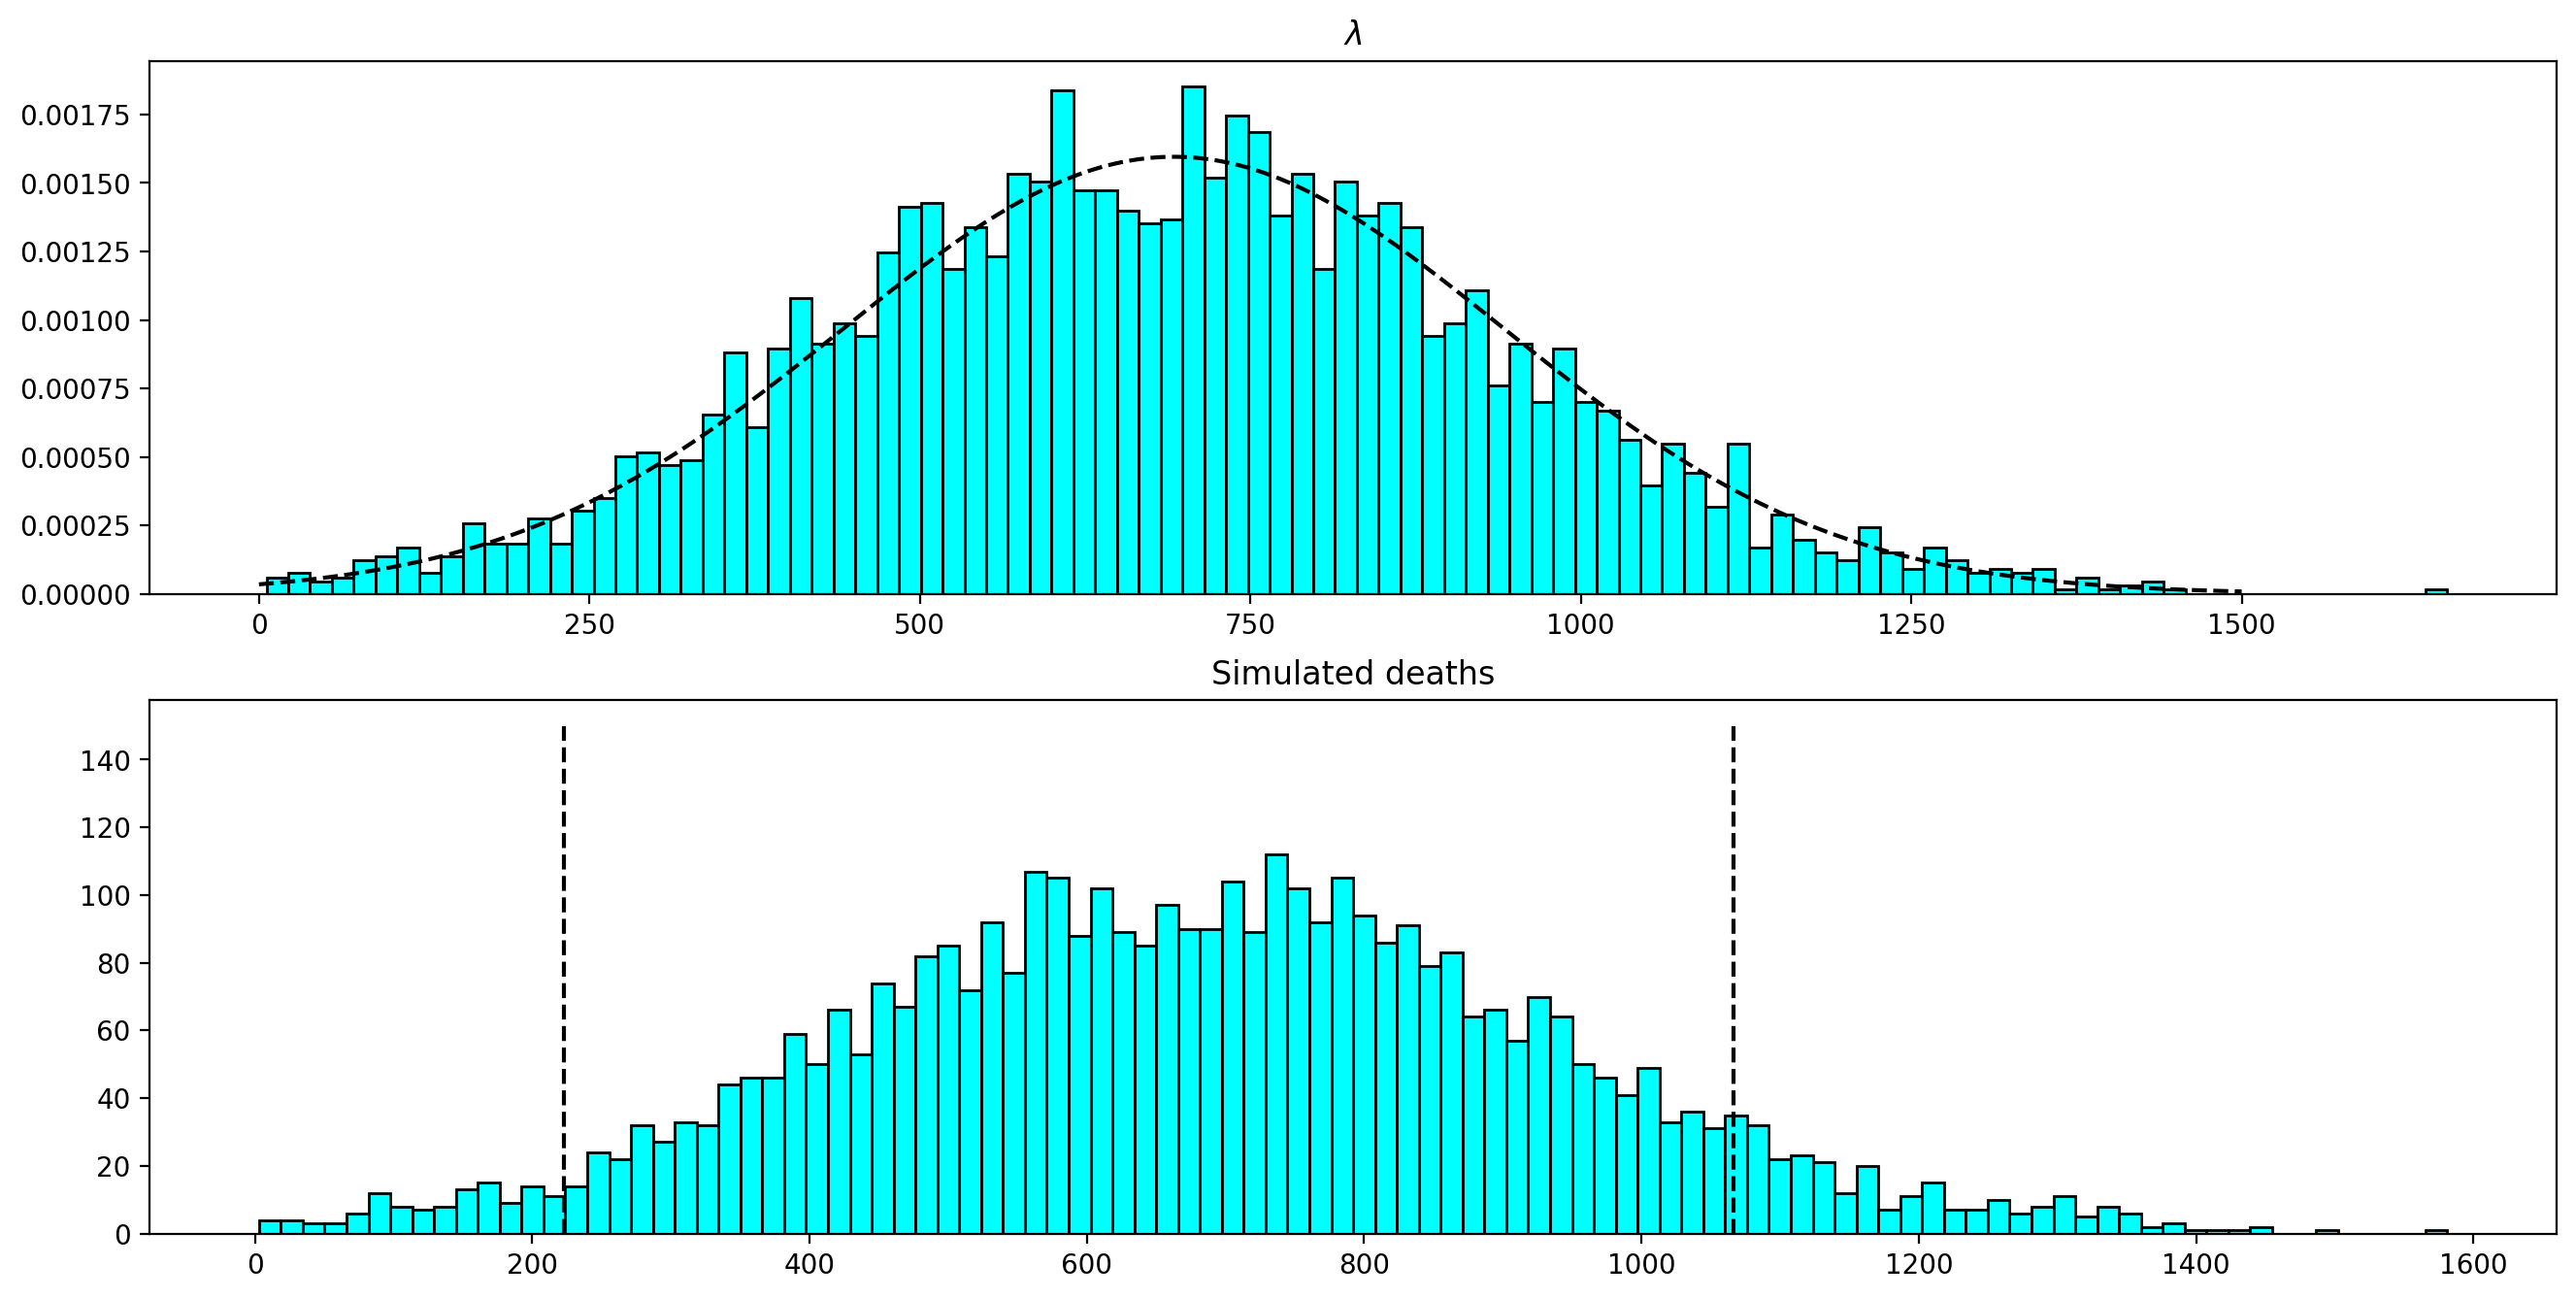

In [47]:
import matplotlib
matplotlib.rcParams['figure.dpi']= 200

plt.figure(figsize=(16, 8))

ax1 = plt.subplot(2, 1, 1)
ax1.hist(lambda_sim, bins=100, color='cyan', edgecolor='k', density=True)
x=np.linspace(0,1500,500)
y=stats.norm.pdf(x,loc=692,scale=250)
ax1.plot(x,y,'k--')
ax1.set_title('$\lambda$')

ax2 = plt.subplot(2, 1, 2)
ax2.hist(deaths_sim, bins=100, color='cyan', edgecolor='k')
ax2.vlines(x=[df['Passenger deaths'].min(), df["Passenger deaths"].max()], ymin=0, ymax=150, linestyle="--")
ax2.set_title("Simulated deaths")

plt.show()

We can see that simulated deaths covers real data, the main probability is between min and max value from data with some external probability outside that range, what is ok.

## Posterior

In [58]:
model_posterior = stan_utility.compile_model('posterior_1.stan')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_854d9fd5dc73f89cfd4bf1b9fd432e9f NOW.


In [61]:
sim = model_posterior.sampling(data=dict(N=len(df['Passenger deaths']),
                                         deaths=df['Passenger deaths']),
                               seed=43541)

lambda_sim = sim.extract()['lambda']
deaths_sim = sim.extract()['deaths_predicted']

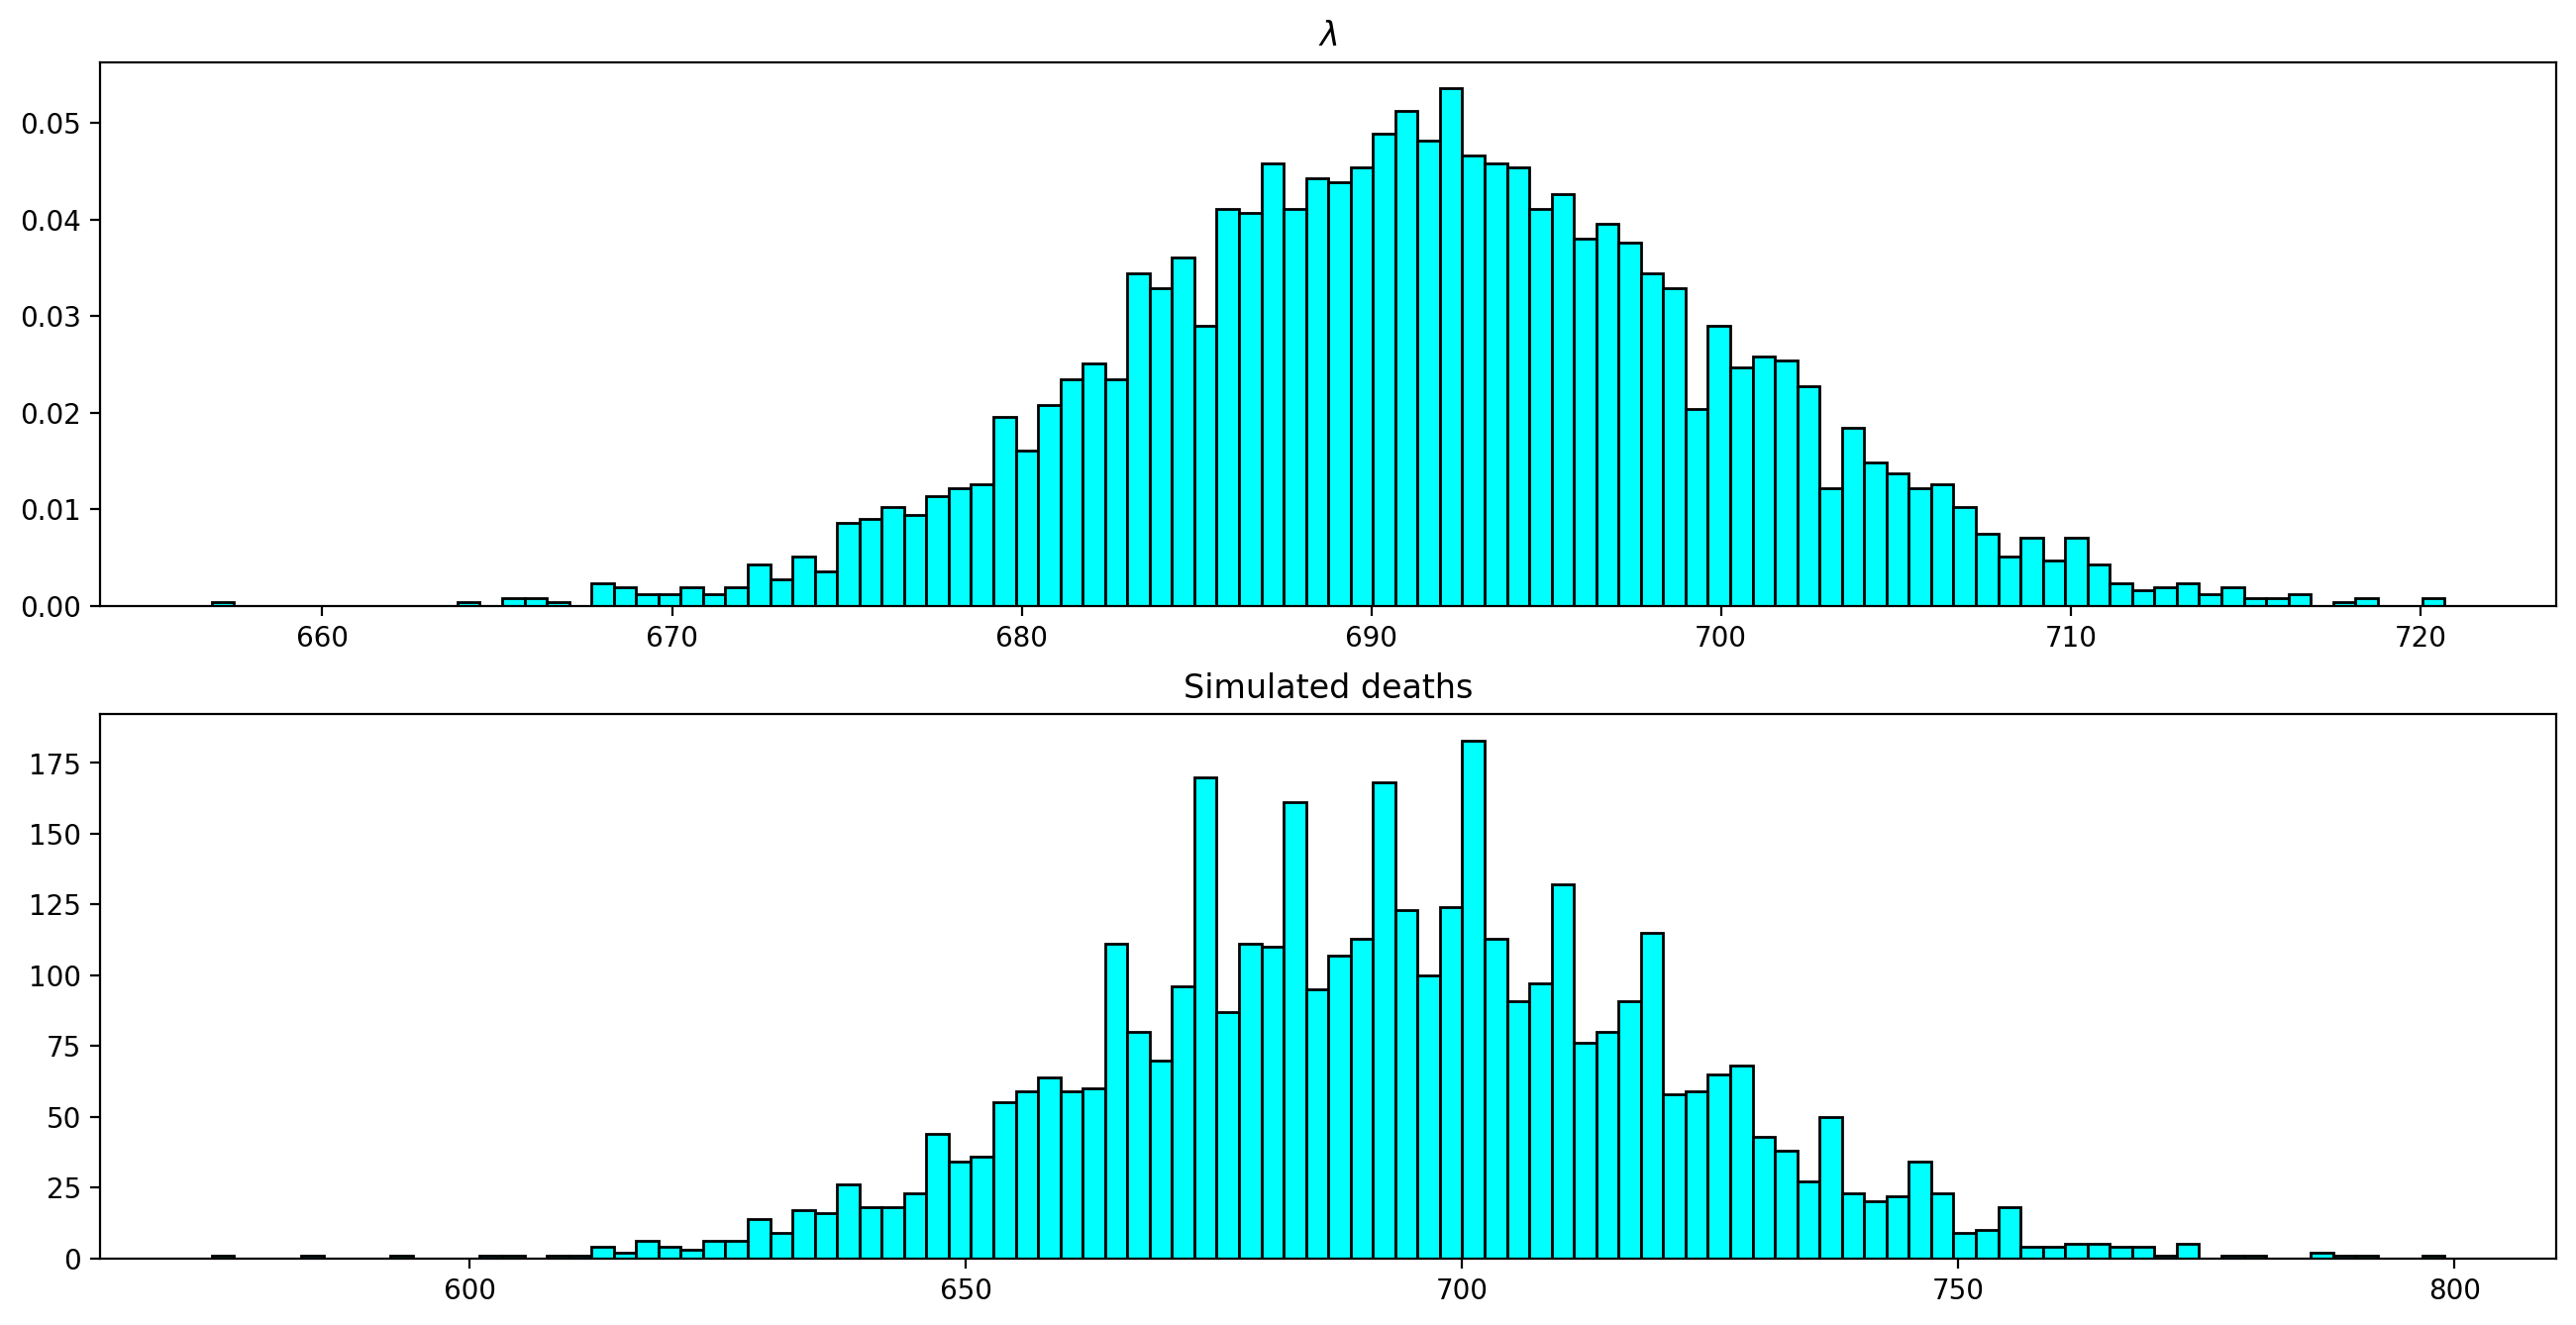

In [62]:
plt.figure(figsize=(16, 8))

ax1 = plt.subplot(2, 1, 1)
ax1.hist(lambda_sim, bins=100, color='cyan', edgecolor='k', density=True)
ax1.set_title('$\lambda$')

ax2 = plt.subplot(2, 1, 2)
ax2.hist(deaths_sim, bins=100, color='cyan', edgecolor='k')
ax2.set_title("Simulated deaths")

plt.show()

In posterior simulated deaths is much more thinner than in prior, out simulation is closer to data.

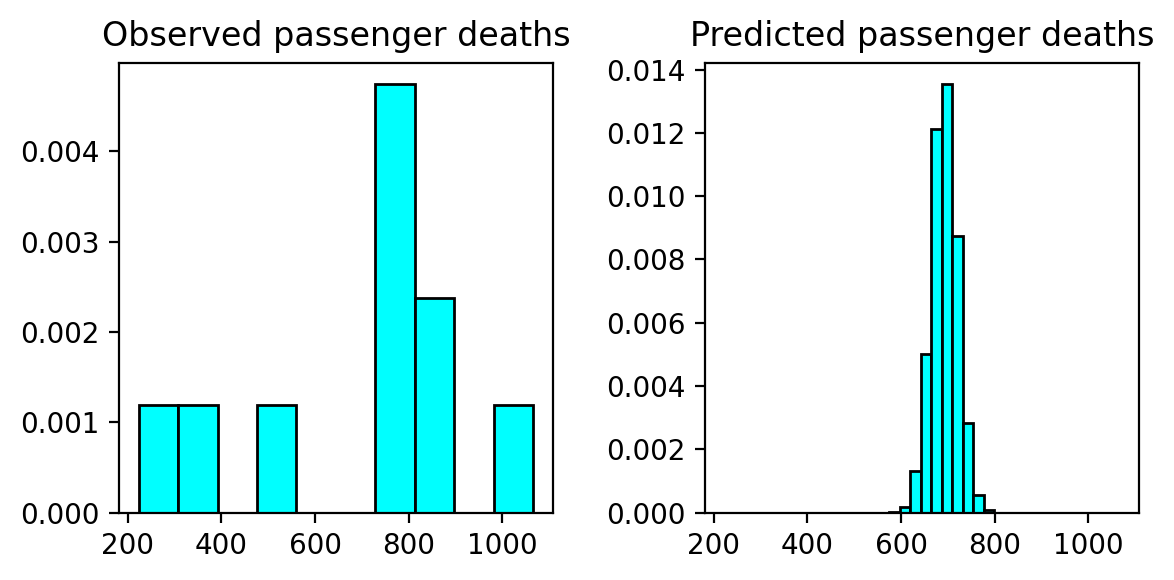

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3), sharex=True)

ax1 = axes[0]
ax1.hist(df['Passenger deaths'], color="cyan" ,edgecolor='k' ,density=True)
ax1.set_title('Observed passenger deaths')

ax2=axes[1]
ax2.hist(deaths_sim, bins=10, color="cyan", edgecolor='k' ,density=True)
ax2.set_title('Predicted passenger deaths')

fig.tight_layout()

plt.show()

The received model predict passenger deaths in much more thinner range in comparison to real data. Input data contains too small amount of records to create good model.

## Task 2

Using the data from following table create a model predicting number of passenger deaths. 
Use poisson distribution, assume that the intensity is constant, but rate is a product of intensity and miles flown.
Select appropriate priors, 
perform prior predictive checks, 
fit the model and using posterior predictive distribution predict the death rates from the model.

In [10]:
intensity = df['Death rate'].mean()
print("For 100 mln miles flown on average {:.3f} people die.".format(intensity))

For 100 mln miles flown on average 0.126 people die.


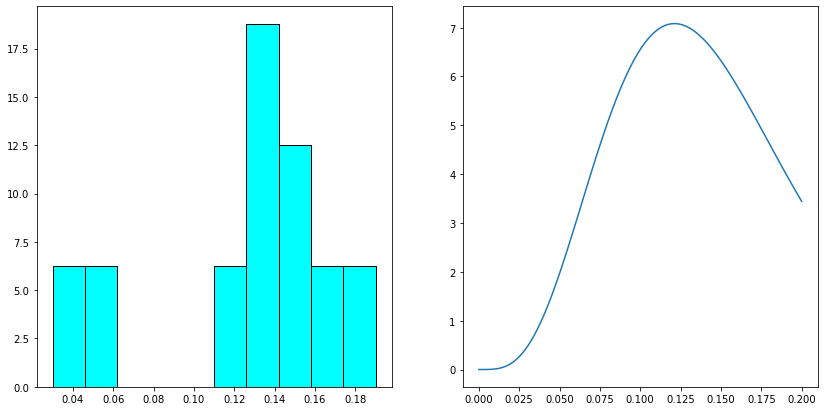

In [51]:
from scipy.stats import beta

plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.hist(df['Death rate'], color="cyan", edgecolor='k' ,density=True)

plt.subplot(1, 2, 2)
x = np.linspace(0, 0.2, 100)
beta_dist = beta(5, 30)
y = beta_dist.pdf(x)
plt.plot(x, y)

plt.show()

In [54]:
import stan_utility
model_prior = stan_utility.compile_model("prior_2.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_954f926ead95525a809d5fd7fbec6b5f NOW.


In [82]:
data = dict(N=10,
            miles_flown = np.linspace(df["Miles flown [100 mln miles]"].min(),
                                      df["Miles flown [100 mln miles]"].max(),
                                      10))
sim = model_prior.sampling(data=data,
                           iter=1000,
                           warmup=0,
                           algorithm='Fixed_param',
                           seed=43541)

beta_sim = sim.extract()['beta']
deaths_sim = sim.extract()['deaths']

Text(0.5, 1.0, 'Miles flown * $\\beta$ (intensity)')

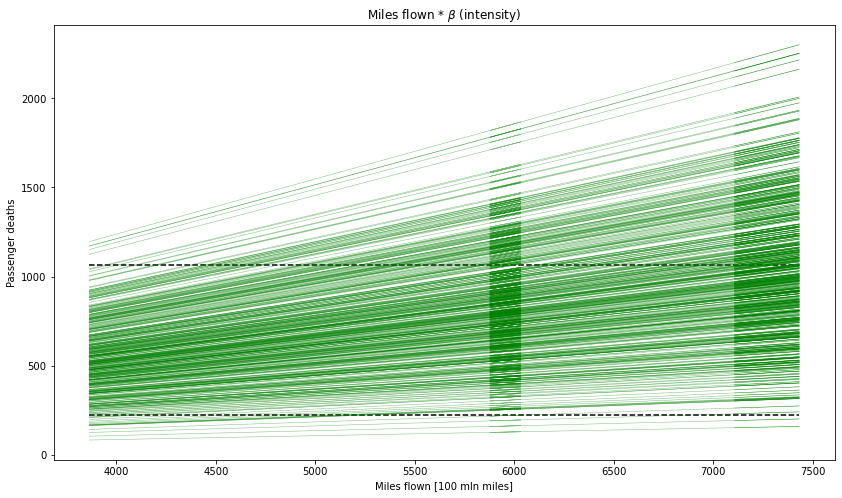

In [95]:
plt.figure(figsize=(14, 8))

for beta_param in beta_sim[:500]:
    plt.plot(df["Miles flown [100 mln miles]"], beta_param*df["Miles flown [100 mln miles]"], color="g", linewidth=0.5, alpha=0.5)

plt.hlines([df["Passenger deaths"].min(),
            df["Passenger deaths"].max()],
           xmin=df["Miles flown [100 mln miles]"].min(),
           xmax=df["Miles flown [100 mln miles]"].max(),
           linestyles='--',
           color="black")

plt.xlabel("Miles flown [100 mln miles]")
plt.ylabel("Passenger deaths")
plt.title(r'Miles flown * $\beta$ (intensity)')

Text(0, 0.5, 'Passenger deaths')

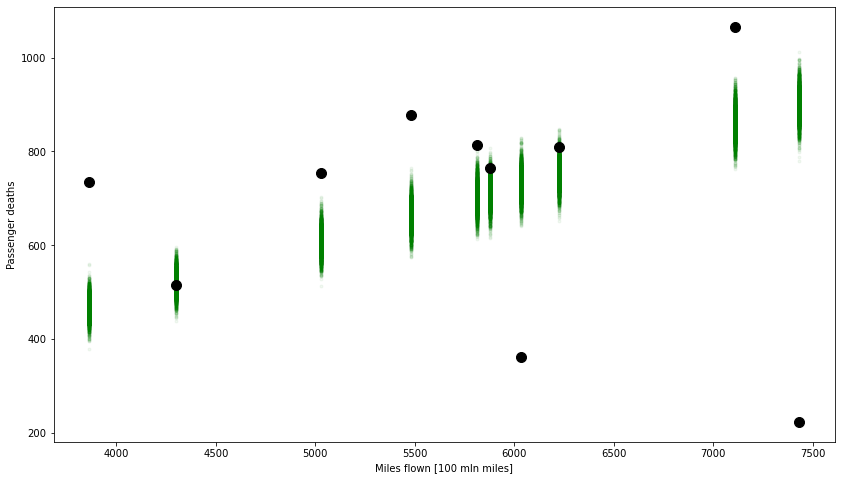

In [152]:
plt.figure(figsize=(14, 8))

for deaths in deaths_sim:
    plt.scatter(data["miles_flown"], deaths, color='g', alpha=0.05, marker='.')
plt.scatter(df['Miles flown [100 mln miles]'], df['Passenger deaths'], color="black", label="Real data", marker='o', s=100)
plt.xlabel('Miles flown [100 mln miles]')
plt.ylabel('Passenger deaths')

Text(0, 0.5, 'Passenger deaths')

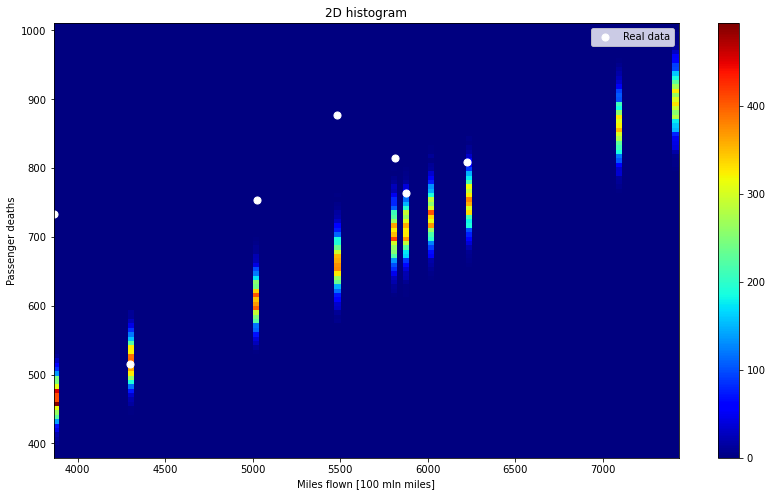

In [157]:
plt.figure(figsize=(14, 8))

y = deaths_sim.flatten()
x = np.array([data["miles_flown"]]*len(deaths_sim)).flatten()

plt.hist2d(x, y, (100, 100), cmap=plt.cm.jet)
plt.colorbar()

plt.scatter(df['Miles flown [100 mln miles]'], df['Passenger deaths'], color="white", label="Real data", marker='o', s=50)
plt.legend()
plt.title("2D histogram")
plt.xlabel('Miles flown [100 mln miles]')
plt.ylabel('Passenger deaths')

We can see that our prior behave quite good, it covers most of the real samples close to most occuring samples from simulation

## Posterior

In [144]:
sim = stan_utility.compile_model("posterior_2.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_b2218434f9e0f1342e8b315957c382e0 NOW.


In [145]:
data = dict(N=len(df),
            input_deaths=df['Passenger deaths'],
            miles_flown=df['Miles flown [100 mln miles]'])
fit = sim.sampling(data=data,
                   seed=43541)

In [146]:
beta_sim=fit.extract()['beta']
lamba_sim=fit.extract()['lambda']
deaths_sim=fit.extract()['deaths']

Text(0.5, 1.0, 'Miles flown * $\\beta$ (intensity)')

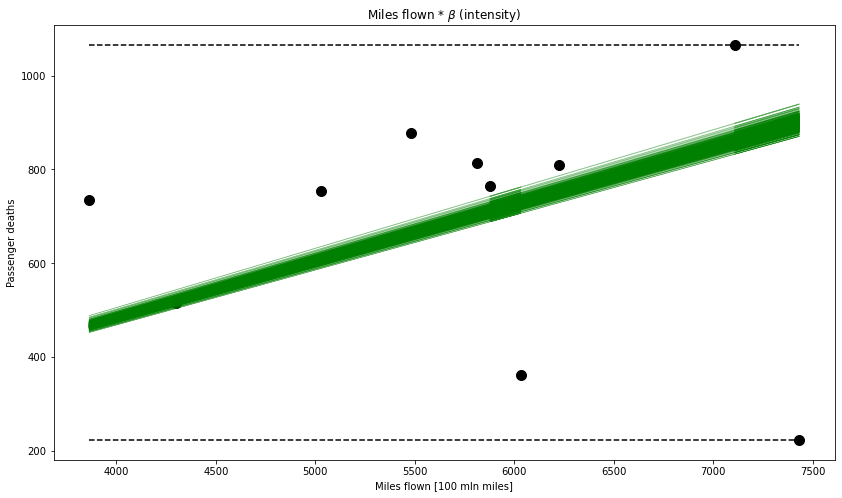

In [159]:
plt.figure(figsize=(14, 8))

for beta_param in beta_sim[:500]:
    plt.plot(df["Miles flown [100 mln miles]"], beta_param*df["Miles flown [100 mln miles]"], color="g", linewidth=0.5, alpha=0.5)

plt.scatter(df['Miles flown [100 mln miles]'], df['Passenger deaths'], color="black", label="Real data", marker='o', s=100)    
    
plt.hlines([df["Passenger deaths"].min(),
            df["Passenger deaths"].max()],
           xmin=df["Miles flown [100 mln miles]"].min(),
           xmax=df["Miles flown [100 mln miles]"].max(),
           linestyles='--',
           color="black")

plt.xlabel("Miles flown [100 mln miles]")
plt.ylabel("Passenger deaths")
plt.title(r'Miles flown * $\beta$ (intensity)')

Text(0, 0.5, 'Passenger deaths')

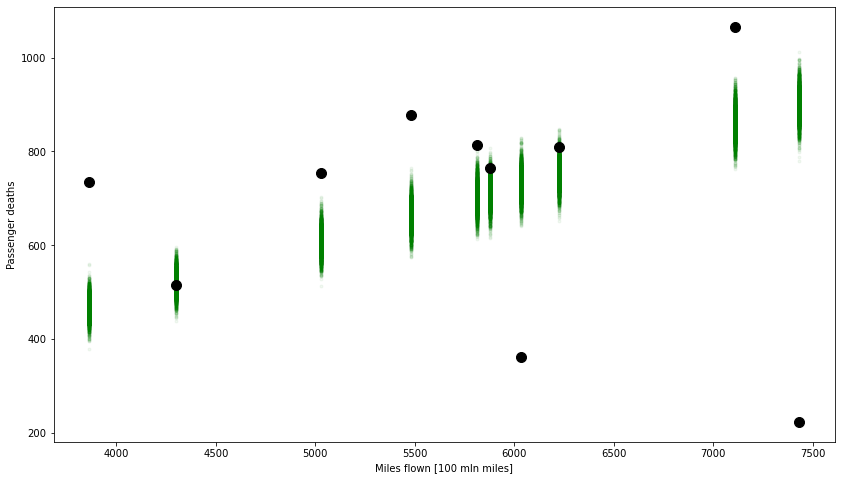

In [151]:
plt.figure(figsize=(14, 8))

for deaths in deaths_sim:
    plt.scatter(data["miles_flown"], deaths, color='g', alpha=0.05, marker='.')
plt.scatter(df['Miles flown [100 mln miles]'], df['Passenger deaths'], color="black", label="Real data", marker='o', s=100)
plt.xlabel('Miles flown [100 mln miles]')
plt.ylabel('Passenger deaths')

Text(0, 0.5, 'Passenger deaths')

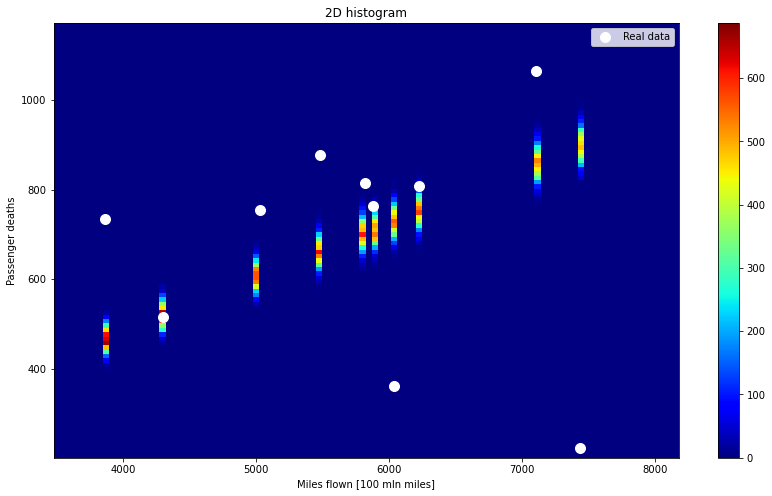

In [158]:
plt.figure(figsize=(14, 8))

y = deaths_sim.flatten()
x = np.array([data["miles_flown"]]*len(deaths_sim)).flatten()

x_min = df['Miles flown [100 mln miles]'].min()*0.9
x_max = df['Miles flown [100 mln miles]'].max()*1.1
y_min = df['Passenger deaths'].min()*0.9
y_max = df['Passenger deaths'].max()*1.1
plt.hist2d(x, y, (100, 100), cmap=plt.cm.jet, range=[[x_min, x_max], [y_min, y_max]])
plt.colorbar()

plt.scatter(df['Miles flown [100 mln miles]'], df['Passenger deaths'], color="white", label="Real data", marker='o', s=100)
plt.legend()
plt.title("2D histogram")
plt.xlabel('Miles flown [100 mln miles]')
plt.ylabel('Passenger deaths')

As we can see out model fits quite well to data but it's stoll far away to describe the situation. The amount of data is really small, so it's hard to evaluate good prediction. Input data are also weak-informtive. To improve model we should consider more factors that have affect on situation. On example every year safety for planes increases and the amount of accident decrease.